In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor(model_ckpt)
model = ViTForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=128,
    problem_type='regression',
)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining

In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

In [4]:
from torchaffectnet.datasets import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])

val_dataset = AffectNetDataset('../Affectnet/validation.csv',
                               images_root,
                               transform=transform)

len(val_dataset)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs

4500

100%|██████████| 4500/4500 [04:02<00:00, 18.52it/s]


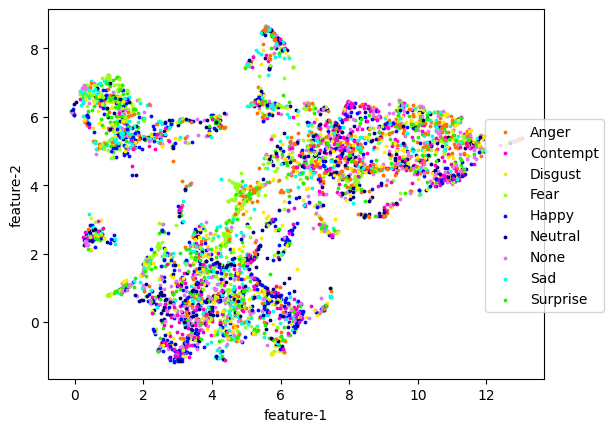

In [12]:
from torchaffectnet.utils import cls_tokens, plot_tokens
from torchaffectnet.const import ID2LABEL

tokens, labels = cls_tokens(model.to(device),
                            feature_extractor,
                            val_dataset,
                            device)
plot_tokens(tokens, labels, 10, ID2LABEL)

In [6]:
from torchaffectnet.datasets import AffectNetDatasetForSupCon

class AffectNetDatasetForSupConWithValence(AffectNetDatasetForSupCon):
    def labeling(self, idx):
        target = torch.tensor(self.df['valence'][idx])
        if target < -0.5:
            return torch.tensor(0)
        elif target > 0.5:
            return torch.tensor(2)
        else:
            return torch.tensor(1)

In [7]:
val_contrastive_dataset = AffectNetDatasetForSupConWithValence('../Affectnet/validation.csv',
                                                               images_root,
                                                               transform=transform)
len(val_contrastive_dataset)

4500

In [8]:
from tqdm import tqdm

def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

In [9]:
from umap.umap_ import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, labels, n_neighbors, id2label):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='right')
    plt.show()

In [10]:
labeled_valence = {
    0: 'valence < -0.5',
    1: '-0.5 <= valence <= 0.5',
    2: '0.5 < valence',
}

100%|██████████| 4500/4500 [07:01<00:00, 10.68it/s]


(4500, 2)
(4500,)


/tmp/ipykernel_34740/436394922.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


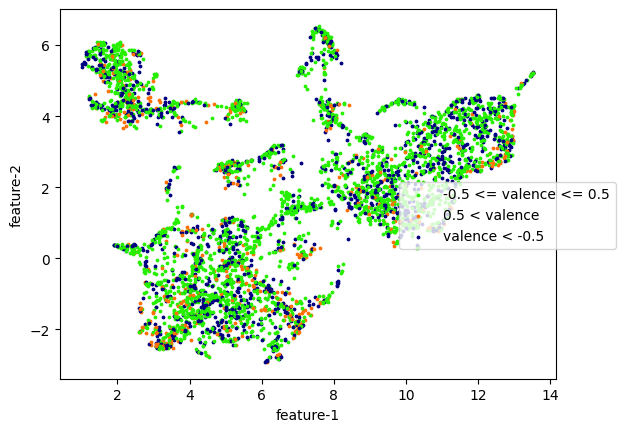

In [11]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_contrastive_dataset,
                            device)
plot_tokens(tokens, labels, 10, labeled_valence)